In [20]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
# Activate auto reload 
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
    
from pyccapt.calibration.data_tools import data_loadcrop
from pyccapt.calibration.data_tools import raw_data_surface_concept
from pyccapt.calibration.calibration.mc_plot import AptHistPlotter
from pyccapt.calibration.data_tools.data_loadcrop import plot_crop_fdm
from pyccapt.calibration.mc import mc_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
filename = 'D:/pyccapt/tests/data/data_1642_Aug-30-2023_16-05_Al_test4.h5'
# filename = 'C:/Users/mehrp/PycharmProjects/pyccapt/tests/data_1642_Aug-30-2023_16-05_Al_test4.h5'
df_dld = data_loadcrop.fetch_dataset_from_dld_grp(filename, extract_mode='dld')

{'apt': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse', 'temperature', 'time_counter'], 'dld': ['high_voltage', 'pulse', 'start_counter', 't', 'x', 'y'], 'tdc': ['channel', 'high_voltage', 'pulse', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}


In [5]:
df_dld

,high_voltage (V),pulse,start_counter,t (ns),x_det (cm),y_det (cm)
0,600.000000,328.0,8202,2537.802979,1.080816,0.006531
1,615.000000,328.0,14741,3686.929443,1.443265,-1.812245
2,624.979980,328.0,2657,3110.466553,-0.688980,-2.249796
3,624.979980,328.0,4568,1171.380737,0.192653,-0.914286
4,634.919983,328.0,4498,2703.307129,0.058776,1.479184
...,...,...,...,...,...,...
12312991,8000.000000,1600.0,11089,3722.090332,2.282449,2.798367
12312992,8000.000000,1600.0,13935,3065.292725,3.725714,-0.675918
12312993,8000.000000,1600.0,2722,2561.627686,3.229388,1.573878
12312994,8000.000000,1600.0,3387,3579.656494,0.414694,2.693877


In [6]:
df_tdc = data_loadcrop.fetch_dataset_from_dld_grp(filename, extract_mode='tdc_sc')

{'apt': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse', 'temperature', 'time_counter'], 'dld': ['high_voltage', 'pulse', 'start_counter', 't', 'x', 'y'], 'tdc': ['channel', 'high_voltage', 'pulse', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}


In [8]:
df_tdc

,channel,start_counter,high_voltage (V),pulse,time_data
0,1,8202,600.0,328.0,92186
1,3,8202,600.0,328.0,92507
2,2,8202,600.0,328.0,92510
3,0,8202,600.0,328.0,92847
4,2,13183,600.0,328.0,85018
...,...,...,...,...,...
59971104,0,9312,8000.0,1600.0,124720
59971105,3,9312,8000.0,1600.0,125864
59971106,2,9312,8000.0,1600.0,125796
59971107,1,14307,8000.0,1600.0,66948


In [43]:
channel = df_tdc['channel'].to_numpy()
start_counter = df_tdc['start_counter'].to_numpy()
time_data = df_tdc['time_data'].to_numpy()
high_voltage = df_tdc['high_voltage (V)'].to_numpy()
pulse = df_tdc['pulse'].to_numpy()

In [45]:
result_4, result_4_invalid, result_3_invalid, result_2_invalid, result_1_invalid, result_other_odd, result_other_even = raw_data_surface_concept.find_consecutive_sequences_seperatly(start_counter, channel, time_data, high_voltage, pulse)
print(len(result_4))
print(len(result_other_odd))
print(len(result_other_even))

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59971109/59971109 [05:24<00:00, 184934.69it/s]


Length of 4 channel: 47481844, 79.17453052268884 %
Length of 4 channel (invalid): 0, 0.0 %
Length of 3 channel: 6532554, 10.89283508163906 %
Length of 2 channel: 3311822, 5.522362442888959 %
Length of 1 channel: 1018779, 1.6987829923238538 %
Length of groups of four (multihit): 872264, 1.4544736866546857 %
Length of not group of four (multihit): 753846, 1.2570152738045914 %
Total length: 59971109
11870461
117835
106639


In [46]:
print(len(result_4))
print(len(result_other_even))
print(len(result_other_odd))

even_ions = 0
odd_ions = 0
ions_4 = 0
for i in range(len(result_4)):         
    ions_4 += result_4[i]['valid_event'].count(True)
for i in range(len(result_other_even)):         
    even_ions += result_other_even[i]['valid_event'].count(True)
for i in range(len(result_other_odd)):         
    odd_ions += result_other_odd[i]['valid_event'].count(True)

print(ions_4)
print(even_ions)
print(odd_ions)
print('maximum possible number of ions:', ions_4 + even_ions + odd_ions)

11870461
106639
117835
11870461
217019
119776
maximum possible number of ions: 12207256


In [47]:
# surface concept tdc specific binning and factors
TOFFACTOR = 27.432 / (1000 * 4)  # 27.432 ps/bin, tof in ns, data is TDC time sum
TOFFACTOR2 = 27.432 / (1000 * 2) 
DETBINS = 4900
BINNINGFAC = 2
XYFACTOR = 80 / DETBINS * BINNINGFAC  # XXX mm/bin
XYBINSHIFT = DETBINS / BINNINGFAC / 2  # to center detector

In [48]:
index = 1
aa = df_dld.iloc[index]
print(aa)
print(result_4[index])
time_data_tmp = np.array(result_4[index]['time_data'], dtype=np.int64)

high_voltage (V)      615.000000
pulse                 328.000000
start_counter       14741.000000
t (ns)               3686.929443
x_det (cm)              1.443265
y_det (cm)             -1.812245
Name: 1, dtype: float64
{'channels': [0, 1, 2, 3], 'time_data': [134846, 133962, 133846, 134956], 'start_counter': [14741, 14741, 14741, 14741], 'valid_event': [True], 'high_voltage': 619.989990234375, 'pulse': 328.0, 'indices': (13, 16), 'length': 4}


In [49]:
xx_dif = time_data_tmp[1] - time_data_tmp[0]
yy_dif = time_data_tmp[3] - time_data_tmp[2]
print(xx_dif, yy_dif)
xx_dif = -0.5*xx_dif + 1225
yy_dif = -0.5*yy_dif + 1225
print(xx_dif, yy_dif)
time = time_data_tmp[0] + time_data_tmp[1] + time_data_tmp[2] + time_data_tmp[3]
time2 = time_data_tmp[0] + time_data_tmp[1]
time3 = time_data_tmp[2] + time_data_tmp[3]
det_x = (((xx_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
det_y = (((yy_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
tof = time * TOFFACTOR
tof2 = time2 * TOFFACTOR2
tof3 = time3 * TOFFACTOR2
print('det_x:', det_x, 'det_y:', det_y, 'tof:', tof, 'tof(1-0):', tof2, 'tof(2-3):', tof3)

-884 1110
1667.0 670.0
det_x: 1.4432653061224492 det_y: -1.8122448979591839 tof: 3686.9293799999996 tof(1-0): 3686.970528 tof(2-3): 3686.888232


In [50]:
det_x_4 = []
det_y_4 = []
tof_4 = []
start_counter_4 = []
high_voltage_4 = []
print('length of result_4:', len(result_4))

for ion in tqdm(result_4, desc="Processing", unit="iteration"):
    if ion['valid_event'][0] == True:
        time_data_tmp = np.array(ion['time_data'], dtype=np.int64)
        xx_dif = time_data_tmp[1] - time_data_tmp[0]
        yy_dif = time_data_tmp[3] - time_data_tmp[2]
        time = time_data_tmp[0] + time_data_tmp[1] + time_data_tmp[2] + time_data_tmp[3]
        xx_dif = -0.5*xx_dif + 1225
        yy_dif = -0.5*yy_dif + 1225
        xx_dif = (((xx_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
        yy_dif = (((yy_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
        if abs(xx_dif) < 4.2 and abs(yy_dif) < 4.2:
            det_x_4.append(xx_dif)
            det_y_4.append(yy_dif)
            tof_4.append(time * TOFFACTOR)
            start_counter_4.append(np.array(ion['start_counter'], dtype=np.int64)[0])
            high_voltage_4.append(ion['high_voltage'])


print(len(det_x_4))
print('loss:', (len(det_x_4) / len(result_4))*100)
    

length of result_4: 11870461


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11870461/11870461 [02:44<00:00, 71948.54iteration/s]

11861459
loss: 99.92416469756313


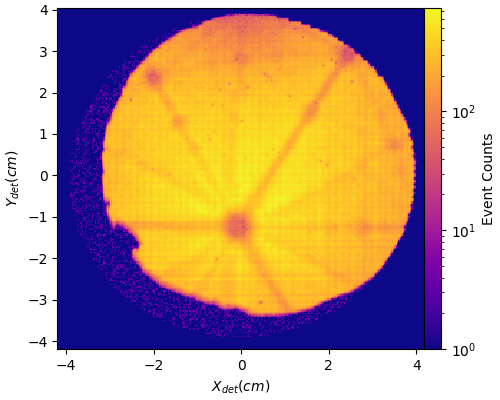

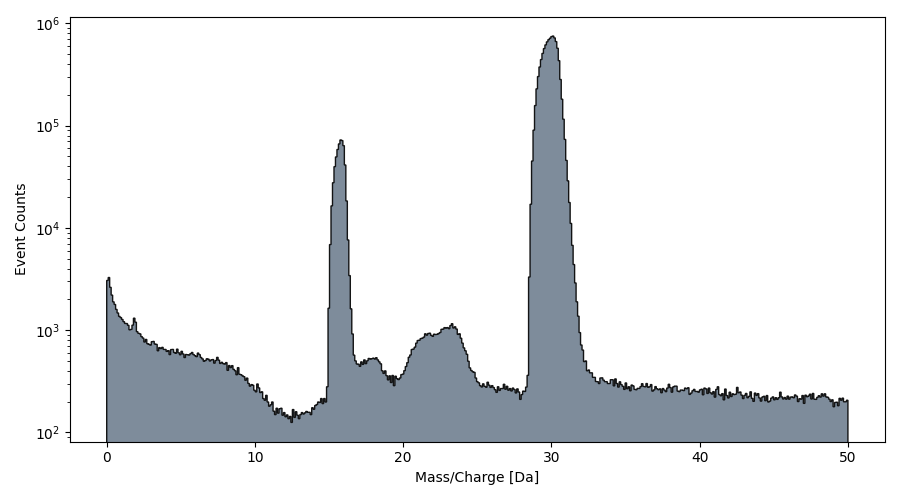

In [51]:
fdm = {'x_det (cm)': det_x_4, 'y_det (cm)': det_y_4}
fdm = pd.DataFrame(fdm)

plot_crop_fdm(fdm)
mc = mc_tools.tof2mc(t=np.array(tof_4), t0=0, V=np.array(high_voltage_4), xDet=np.array(det_x_4), yDet=np.array(det_y_4), flightPathLength=110, V_pulse=np.zeros(len(tof_4)), mode='voltage')
mc_plot = AptHistPlotter(mc[mc<50])
y_hist, x_hist = mc_plot.plot_histogram()

In [52]:
det_x_even = []
det_y_even = []
tof_even = []
start_counter_even = []
high_voltage_even = []
print('length of result_4:', len(result_other_even))

for ion in tqdm(result_other_even, desc="Processing", unit="iteration"):
    time_data_tmp = np.array(ion['time_data'], dtype=np.int64)
    for index, event in enumerate(ion['valid_event']):
        if event == True:
            xx_dif = time_data_tmp[index*4 + 1] - time_data_tmp[index*4 + 0]
            yy_dif = time_data_tmp[index*4 + 3] - time_data_tmp[index*4 + 2]
            time = time_data_tmp[index*4 + 0] + time_data_tmp[index*4 + 1] + time_data_tmp[index*4 + 2] + time_data_tmp[index*4 + 3]
            xx_dif = -0.5*xx_dif + 1225
            yy_dif = -0.5*yy_dif + 1225
            xx_dif = (((xx_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
            yy_dif = (((yy_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
            if abs(xx_dif) < 4.2 and abs(yy_dif) < 4.2:
                det_x_even.append(xx_dif)
                det_y_even.append(yy_dif)
                tof_even.append(time * TOFFACTOR)
                start_counter_even.append(np.array(ion['start_counter'], dtype=np.int64)[0])
                high_voltage_even.append(ion['high_voltage'])

print(len(det_x_even))
    

length of result_4: 106639


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106639/106639 [00:03<00:00, 34860.59iteration/s]

215918


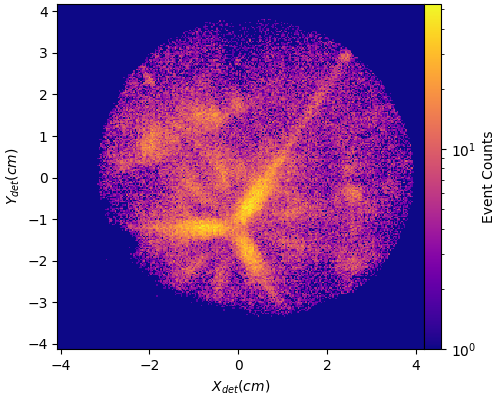

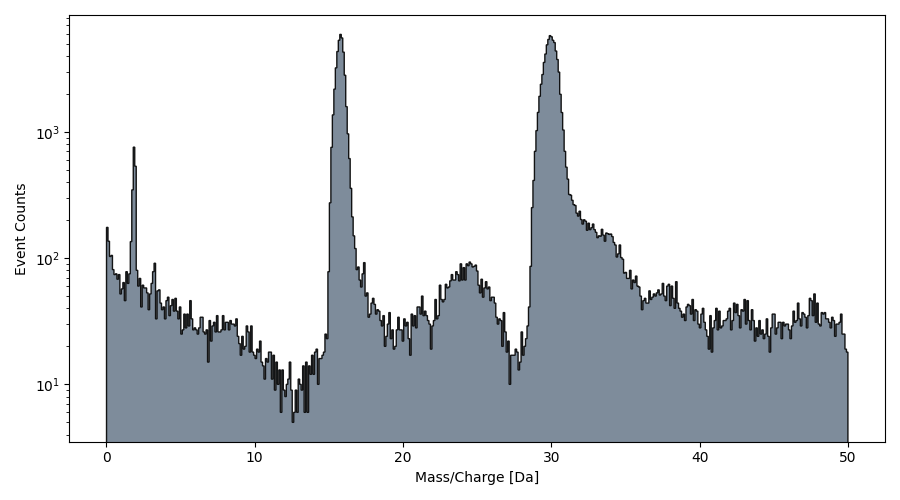

In [53]:
fdm = {'x_det (cm)': det_x_even, 'y_det (cm)': det_y_even}
fdm = pd.DataFrame(fdm)

plot_crop_fdm(fdm)
mc = mc_tools.tof2mc(t=np.array(tof_even), t0=0, V=np.array(high_voltage_even), xDet=np.array(det_x_even), yDet=np.array(det_y_even), flightPathLength=110, V_pulse=np.zeros(len(tof_even)), mode='voltage')
mc_plot = AptHistPlotter(mc[mc<50])
y_hist, x_hist = mc_plot.plot_histogram()

In [54]:
det_x_odd = []
det_y_odd = []
tof_odd = []
start_counter_odd = []
high_voltage_odd = []
print('length of result_4:', len(result_other_odd))

for ion in tqdm(result_other_odd, desc="Processing", unit="iteration"):
    time_data_tmp = np.array(ion['time_data'], dtype=np.int64)
    for index, event in enumerate(ion['valid_event']):
        if event == True:
            xx_dif = time_data_tmp[index*4 + 1] - time_data_tmp[index*4 + 0]
            yy_dif = time_data_tmp[index*4 + 3] - time_data_tmp[index*4 + 2]
            time = time_data_tmp[index*4 + 0] + time_data_tmp[index*4 + 1] + time_data_tmp[index*4 + 2] + time_data_tmp[index*4 + 3]
            xx_dif = -0.5*xx_dif + 1225
            yy_dif = -0.5*yy_dif + 1225
            xx_dif = (((xx_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
            yy_dif = (((yy_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
            if abs(xx_dif) < 4.2 and abs(yy_dif) < 4.2:
                det_x_odd.append(xx_dif)
                det_y_odd.append(yy_dif)
                tof_odd.append(time * TOFFACTOR)
                start_counter_odd.append(np.array(ion['start_counter'], dtype=np.int64)[0])
                high_voltage_odd.append(ion['high_voltage'])

print(len(det_x_odd))

length of result_4: 117835


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 117835/117835 [00:01<00:00, 59784.06iteration/s]

86495


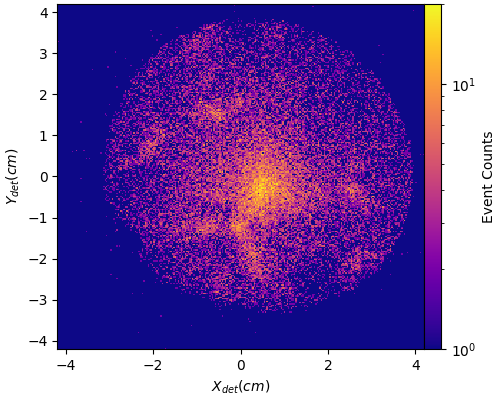

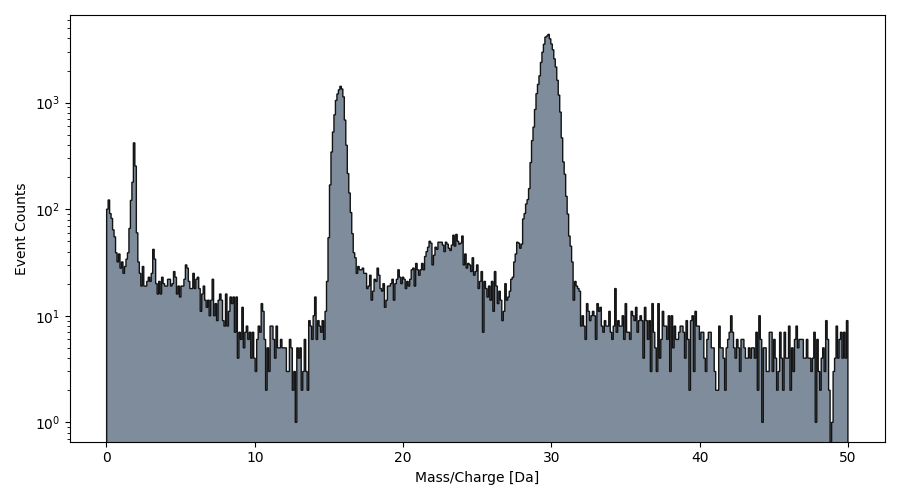

In [55]:
fdm = {'x_det (cm)': det_x_odd, 'y_det (cm)': det_y_odd}
fdm = pd.DataFrame(fdm)

plot_crop_fdm(fdm)
mc = mc_tools.tof2mc(t=np.array(tof_odd), t0=0, V=np.array(high_voltage_odd), xDet=np.array(det_x_odd), yDet=np.array(det_y_odd), flightPathLength=110, V_pulse=np.zeros(len(tof_odd)), mode='voltage')
mc_plot = AptHistPlotter(mc[mc<50])
y_hist, x_hist = mc_plot.plot_histogram()

In [56]:
result_other_even[2]

{'channels': [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
 'time_data': [6859,
  7183,
  7990,
  6051,
  30651,
  30914,
  31749,
  29820,
  38572,
  38672,
  39344,
  37901],
 'start_counter': [1965,
  1965,
  1965,
  1965,
  1965,
  1965,
  1965,
  1965,
  1965,
  1965,
  1965,
  1965],
 'valid_event': [True, True, True],
 'high_voltage': 2799.02001953125,
 'pulse': 559.8040161132812,
 'indices': (4097, 4108),
 'length': 12}

In [57]:
result_other_odd[16]

{'channels': [0, 1, 2, 3, 0, 3],
 'time_data': [28140, 29673, 29510, 28288, 28645, 28788],
 'start_counter': [2353, 2353, 2353, 2353, 2353, 2353],
 'valid_event': [True, False],
 'high_voltage': 3151.43994140625,
 'pulse': 630.2880249023438,
 'indices': (5714, 5719),
 'length': 6}

In [64]:
result_total = raw_data_surface_concept.find_consecutive_sequences(start_counter, channel, time_data, high_voltage, pulse, print_stats=True)

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59971109/59971109 [04:38<00:00, 215621.01it/s]


Length of 4 channel: 11870461, 79.17453052268884 %
Length of 4 channel (invalid): 0, 0.0 %
Length of 3 channel: 2177518, 10.89283508163906 %
Length of 2 channel: 1655911, 5.522362442888959 %
Length of 1 channel: 1018779, 1.6987829923238538 %
Length of groups of four channel (multihit) (multihit): 872264, 1.4544736866546857 %
Length of not group of four channel (multihit): 753846, 1.2570152738045914 %
Total length: 59971109


In [66]:
det_x_total = []
det_y_total = []
tof_total = []
start_counter_total = []
high_voltage_total = []
pulse_total = []
print('length of result_total:', len(result_total))

for ion in tqdm(result_total, desc="Processing", unit="iteration"):
    time_data_tmp = np.array(ion['time_data'], dtype=np.int64)
    for index, event in enumerate(ion['valid_event']):
        if event == True:
            xx_dif = time_data_tmp[index*4 + 1] - time_data_tmp[index*4 + 0]
            yy_dif = time_data_tmp[index*4 + 3] - time_data_tmp[index*4 + 2]
            time = time_data_tmp[index*4 + 0] + time_data_tmp[index*4 + 1] + time_data_tmp[index*4 + 2] + time_data_tmp[index*4 + 3]
            xx_dif = -0.5*xx_dif + 1225
            yy_dif = -0.5*yy_dif + 1225
            xx_dif = (((xx_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
            yy_dif = (((yy_dif - XYBINSHIFT) * XYFACTOR) * 0.1)
            if abs(xx_dif) < 4.2 and abs(yy_dif) < 4.2:
                det_x_total.append(xx_dif)
                det_y_total.append(yy_dif)
                tof_total.append(time * TOFFACTOR)
                start_counter_total.append(np.array(ion['start_counter'], dtype=np.int64)[0])
                high_voltage_total.append(ion['high_voltage'])
                pulse_total.append(ion['pulse'])

print(len(det_x_total))

length of result_total: 16947143


Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16947143/16947143 [02:36<00:00, 108593.65iteration/s]

11861459


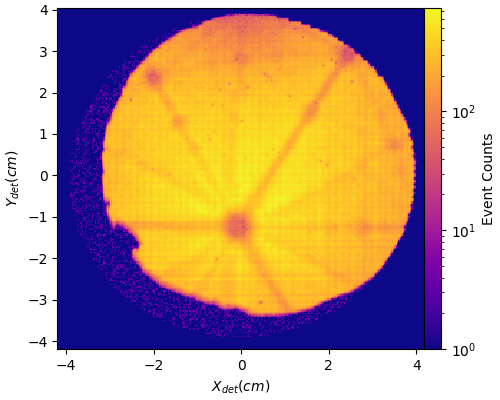

d:\pyccapt\pyccapt\calibration\calibration\mc_plot.py:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(figsize=fig_size)


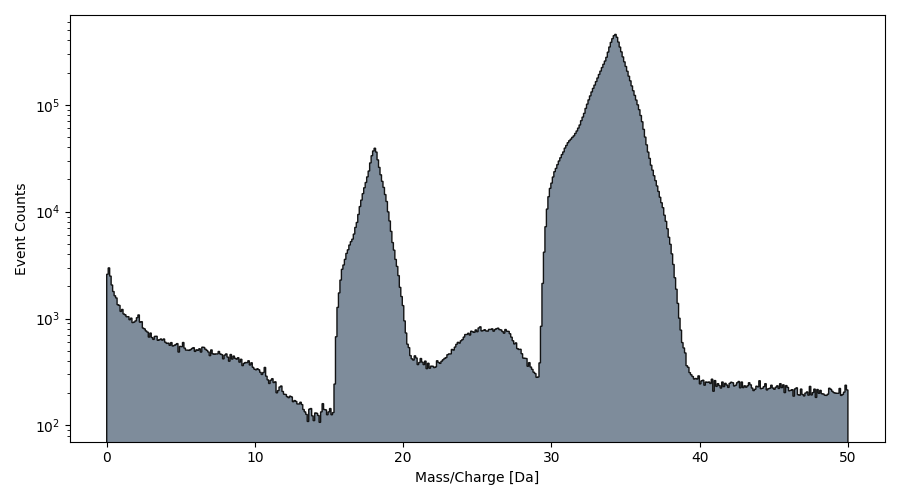

In [68]:
fdm = {'x_det (cm)': det_x_total, 'y_det (cm)': det_y_total}
fdm = pd.DataFrame(fdm)

plot_crop_fdm(fdm)
mc = mc_tools.tof2mc(t=np.array(tof_total), t0=0, V=np.array(high_voltage_total), xDet=np.array(det_x_total), yDet=np.array(det_x_total), flightPathLength=110, V_pulse=np.array(pulse_total), mode='voltage')
mc_plot = AptHistPlotter(mc[mc<50])
y_hist, x_hist = mc_plot.plot_histogram()

In [ ]:
# Create a dictionary with the lists
data_total = {
        'high_voltage (V)': high_voltage_total,
        'pulse': pulse_total,
        'start_counter': start_counter_total,
        't (ns)': tof_total,
        'x_det (cm)': det_x_total,
        'y_det (cm)': det_y_total,
}
					
# Create a DataFrame
df_total = pd.DataFrame(data_total)

In [ ]:
df_total.to_hdf(filename='analyzed_raw_data', key='df', mode='w')